In [1]:
# import face_recognition
from deepface import DeepFace
from deepface.detectors import FaceDetector
import cv2
# from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11828999219935842389
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23319825664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9798007892240830603
physical_device_desc: "device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:41:00.0, compute capability: 7.5"
]


In [33]:
'''
image_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/10686.jpg'
image4 = cv2.imread(image_path)

# using deepface
detector_name = 'retinaface'
detector = FaceDetector.build_model(detector_name)
face_locations_deep = FaceDetector.detect_faces(detector, detector_name, image4)

print(len(face_locations_deep))
if len(face_locations_deep)>0:
    for box, face in face_locations_deep:
        #cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
        cv2.rectangle(image4, (face[0], face[1]), (face[0]+face[2],face[1]+face[3]), (0,255,100), 3) 
    fig = plt.figure(figsize=(15,7.5)) 
    plt.imshow(image4)
    plt.show() 
'''

"\nimage_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/10686.jpg'\nimage4 = cv2.imread(image_path)\n\n# using deepface\ndetector_name = 'retinaface'\ndetector = FaceDetector.build_model(detector_name)\nface_locations_deep = FaceDetector.detect_faces(detector, detector_name, image4)\n\nprint(len(face_locations_deep))\nif len(face_locations_deep)>0:\n    for box, face in face_locations_deep:\n        #cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations\n        cv2.rectangle(image4, (face[0], face[1]), (face[0]+face[2],face[1]+face[3]), (0,255,100), 3) \n    fig = plt.figure(figsize=(15,7.5)) \n    plt.imshow(image4)\n    plt.show() \n"

In [34]:
# im = cv2.imread('../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/10686.jpg')
# im_tensor, im_info, im_scale = preprocess.preprocess_image(im, True)
# test_output = model(im_tensor)

# print(postprocess_function(test_output, im_info, im_scale))

In [35]:
# print(im_tensor.shape, im_info, im_scale, len(test_output))

## Testing

In [2]:
from pathlib import Path
import json
import cv2

json_path = '../../../../mnt/DATA/datasets/soccernet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa/Labels-v2.json'
with open(json_path) as f:
    data = json.load(f)
annotations = data['annotations']
for i in range(0, len(annotations)):
    if annotations[i]['gameTime'][0] == '2':
        index = i
        break
an1 = annotations[:index]
an2 = annotations[index:]
actions = [an1, an2]

In [3]:
def first_last_frame(frame_num, seconds_window, fs, num_frames):
    first = max(frame_num - (seconds_window * fs), 1)
    last = min(num_frames, frame_num + (seconds_window * fs))
    return first, last

def get_frame(position, fs):
    return (position // 1000) * fs

In [4]:
# -- 1. Valid and invalid frames --

In [6]:
frames_dir = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa/1_HQ/frames')
half = 0
seconds_window = 10
fs = 8
num_frames = len(list(frames_dir.glob('*.jpg')))

valid_frames = set()
for action in actions[half]:
    position = int(action['position'])
    frame_num = get_frame(position, fs)
    first_action_frame, last_action_frame = first_last_frame(frame_num, seconds_window, fs, num_frames)
    for frame_id in range(first_action_frame, last_action_frame+1):
        valid_frames.add(frame_id)

invalid_frames = list(set(np.arange(num_frames)) - valid_frames)
valid_frames = sorted(valid_frames)
# os.remove(invalid_frames)
#frames_dir.joinpath(str(f'{invalid_frames[0]:05}')+'.jpg')

In [7]:
for frame in invalid_frames[1:]:
    os.remove(frames_dir.joinpath(f'{frame:05}.jpg'))

In [10]:
# -- 2. Generator --

In [11]:
from retinaface.commons import preprocess

class FaceFeeder():

    def __init__(self, directory, valid_frames, batch_size):
        
        self.directory = Path(directory)
        self.valid_frames = valid_frames
        self.batch_size = batch_size
        
        batch_list = []
        for i in range(0, len(self.valid_frames), self.batch_size):
            batch_list.append(self.valid_frames[i:i+self.batch_size])
        self.batch_list = batch_list
        
    def __len__(self):
        return int(np.ceil(len(self.valid_frames)/self.batch_size))
    
    def load_image(self, args):
        img = cv2.imread(args)
        return preprocess.preprocess_image(img, True)
    
    def __getitem__(self, index):
        
        batch = np.zeros([self.batch_size, 1024, 1820, 3])
        im_infos = []
        im_scales = []
        
        for idx, num in enumerate(self.batch_list[index]):
            frame_path = str(self.directory.joinpath(str(f'{num:05}')+'.jpg'))
            im_tensor, im_info, im_scale = self.load_image(frame_path)
            
            #im = cv2.imread(str(self.directory.joinpath(str(f'{num:05}')+'.jpg')))
            #im_tensor, im_info, im_scale = preprocess.preprocess_image(im, True)
            
            batch[idx,:,:,:] = im_tensor
            im_infos.append(im_info)
            im_scales.append(im_scale)
            
        return batch, im_infos, im_scales


In [12]:
# -- 3. Detection --

In [13]:
from deepface.detectors import RetinaFaceWrapper
from PIL import Image
import math
from deepface.commons import distance
from retinaface import RetinaFace
from retinaface.model import retinaface_model
import tensorflow as tf

In [14]:
# for index in range(len(f.batch_list)):
    # if 10686 in f.batch_list[index]:
        # print(index)

In [15]:
from detect_faces import FaceFeeder

In [16]:
f = FaceFeeder(frames_dir,valid_frames,10)
print(f.__len__())
# f.__getitem__(0)

1203


In [17]:
batch, im_infos, im_scales = f.__getitem__(648) # courtois 648
frame_ids = f.batch_list[648]
frame_ids

[10684, 10685, 10686, 10687, 10688, 10689, 10690, 10691, 10692, 10693]

In [18]:
# detector = RetinaFace.build_model()
model = retinaface_model.build_model()
outputs = model(batch)
type(outputs[0])

tensorflow.python.framework.ops.EagerTensor

In [21]:
results = []
outputs2 = [elt.numpy() for elt in outputs]

# meu
faces = {}

for i, frame_id in enumerate(frame_ids):    
    
    output = [np.expand_dims(outputs2[j][i, ...], axis=0) for j in range(9)]
    faces[f'{frame_id:05}'] = postprocess_function(output, im_infos[i], im_scales[i])
    #results.append(postprocess_function(output, im_infos[i], im_scales[i]))
faces

{'10684': {'face_1': {'score': 0.9996418952941895,
   'facial_area': [896, 100, 1026, 284],
   'landmarks': {'right_eye': [909.09717, 166.21964],
    'left_eye': [953.20496, 165.40382],
    'nose': [909.2216, 202.04907],
    'mouth_right': [916.47107, 237.51549],
    'mouth_left': [950.89764, 236.18353]}}},
 '10685': {'face_1': {'score': 0.9995372295379639,
   'facial_area': [954, 105, 1088, 290],
   'landmarks': {'right_eye': [970.64246, 166.8767],
    'left_eye': [1020.453, 170.39282],
    'nose': [974.5613, 205.61703],
    'mouth_right': [971.1954, 240.9073],
    'mouth_left': [1009.4236, 244.34096]}}},
 '10686': {'face_1': {'score': 0.9994783997535706,
   'facial_area': [1001, 134, 1134, 319],
   'landmarks': {'right_eye': [1017.06866, 197.37823],
    'left_eye': [1068.7372, 200.65515],
    'nose': [1021.3234, 233.47261],
    'mouth_right': [1016.45233, 271.3849],
    'mouth_left': [1054.9336, 274.7659]}}},
 '10687': {'face_1': {'score': 0.9995951056480408,
   'facial_area': [1030,

In [23]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10540761645639066866
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23491946752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4118792044972986394
physical_device_desc: "device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:41:00.0, compute capability: 7.5"
]


In [25]:
import cv2
from retinaface.RetinaFace import get_image
from retinaface.commons import preprocess, postprocess


def postprocess_function(net_out, im_info, im_scale, threshold=0.9):

    nms_threshold = 0.4; decay4=0.5

    _feat_stride_fpn = [32, 16, 8]

    _anchors_fpn = {
        'stride32': np.array([[-248., -248.,  263.,  263.], [-120., -120.,  135.,  135.]], dtype=np.float32),
        'stride16': np.array([[-56., -56.,  71.,  71.], [-24., -24.,  39.,  39.]], dtype=np.float32),
        'stride8': np.array([[-8., -8., 23., 23.], [ 0.,  0., 15., 15.]], dtype=np.float32)
    }

    _num_anchors = {'stride32': 2, 'stride16': 2, 'stride8': 2}
    
    proposals_list = []
    scores_list = []
    landmarks_list = []
    
    # net_out = [elt.numpy() for elt in net_out]
    sym_idx = 0
    
    for _idx, s in enumerate(_feat_stride_fpn):
        _key = 'stride%s'%s
        
        scores = net_out[sym_idx]
        scores = scores[:, :, :, _num_anchors['stride%s'%s]:]

        bbox_deltas = net_out[sym_idx + 1]
        height, width = bbox_deltas.shape[1], bbox_deltas.shape[2]

        A = _num_anchors['stride%s'%s]
        K = height * width
        anchors_fpn = _anchors_fpn['stride%s'%s]
        anchors = postprocess.anchors_plane(height, width, s, anchors_fpn)
        anchors = anchors.reshape((K * A, 4))
        scores = scores.reshape((-1, 1))

        bbox_stds = [1.0, 1.0, 1.0, 1.0]
        bbox_deltas = bbox_deltas
        bbox_pred_len = bbox_deltas.shape[3]//A
        bbox_deltas = bbox_deltas.reshape((-1, bbox_pred_len))
        bbox_deltas[:, 0::4] = bbox_deltas[:,0::4] * bbox_stds[0]
        bbox_deltas[:, 1::4] = bbox_deltas[:,1::4] * bbox_stds[1]
        bbox_deltas[:, 2::4] = bbox_deltas[:,2::4] * bbox_stds[2]
        bbox_deltas[:, 3::4] = bbox_deltas[:,3::4] * bbox_stds[3]
        proposals = postprocess.bbox_pred(anchors, bbox_deltas)

        proposals = postprocess.clip_boxes(proposals, im_info[:2])

        if s==4 and decay4<1.0:
            scores *= decay4

        scores_ravel = scores.ravel()
        order = np.where(scores_ravel>=threshold)[0]
        proposals = proposals[order, :]
        scores = scores[order]

        proposals[:, 0:4] /= im_scale
        proposals_list.append(proposals)
        scores_list.append(scores)

        landmark_deltas = net_out[sym_idx + 2]
        landmark_pred_len = landmark_deltas.shape[3]//A
        landmark_deltas = landmark_deltas.reshape((-1, 5, landmark_pred_len//5))
        landmarks = postprocess.landmark_pred(anchors, landmark_deltas)
        landmarks = landmarks[order, :]

        landmarks[:, :, 0:2] /= im_scale
        landmarks_list.append(landmarks)
        sym_idx += 3

    proposals = np.vstack(proposals_list)
    if proposals.shape[0]==0:
        landmarks = np.zeros( (0,5,2) )
        return {}# np.zeros( (0,5) ), landmarks # CANVI JOSEP
    scores = np.vstack(scores_list)
    scores_ravel = scores.ravel()
    order = scores_ravel.argsort()[::-1]

    proposals = proposals[order, :]
    scores = scores[order]
    landmarks = np.vstack(landmarks_list)
    landmarks = landmarks[order].astype(np.float32, copy=False)

    pre_det = np.hstack((proposals[:,0:4], scores)).astype(np.float32, copy=False)

    #nms = cpu_nms_wrapper(nms_threshold)
    #keep = nms(pre_det)
    keep = postprocess.cpu_nms(pre_det, nms_threshold)

    det = np.hstack( (pre_det, proposals[:,4:]) )
    det = det[keep, :]
    landmarks = landmarks[keep]

    resp = {}
    for idx, face in enumerate(det):
        
        label = 'face_'+str(idx+1)
        resp[label] = {}
        resp[label]["score"] = face[4]

        resp[label]["facial_area"] = list(face[0:4].astype(int))

        resp[label]["landmarks"] = {}
        resp[label]["landmarks"]["right_eye"] = list(landmarks[idx][0])
        resp[label]["landmarks"]["left_eye"] = list(landmarks[idx][1])
        resp[label]["landmarks"]["nose"] = list(landmarks[idx][2])
        resp[label]["landmarks"]["mouth_right"] = list(landmarks[idx][3])
        resp[label]["landmarks"]["mouth_left"] = list(landmarks[idx][4])


    return resp

# Testing the results

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [4]:
# os.listdir('../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/')
detections_path = '../../../mnt/DATA/datasets/soccernet/italy_serie-a/2015-2016/2015-11-22 - 22-45 Inter 4 - 0 Frosinone/face_detection_results_1_HQ.npy'
face_detections = np.load(detections_path, allow_pickle=True)
faces = face_detections[0]
faces

{'00001': {'face_1': {'score': 0.9993096590042114,
   'facial_area': [878, 82, 1128, 430],
   'landmarks': {'right_eye': [1012.3105, 226.40411],
    'left_eye': [1100.9515, 232.51994],
    'nose': [1085.1857, 301.25717],
    'mouth_right': [1005.8854, 355.28723],
    'mouth_left': [1069.0194, 360.66965]}}},
 '00002': {'face_1': {'score': 0.9812705516815186,
   'facial_area': [702, 593, 711, 605],
   'landmarks': {'right_eye': [707.77637, 598.24],
    'left_eye': [710.44116, 597.60956],
    'nose': [710.6012, 600.4063],
    'mouth_right': [708.8059, 602.89545],
    'mouth_left': [710.6876, 602.5512]}},
  'face_2': {'score': 0.9721314907073975,
   'facial_area': [761, 586, 769, 597],
   'landmarks': {'right_eye': [762.3145, 590.49927],
    'left_eye': [764.3969, 590.6732],
    'nose': [762.107, 593.0833],
    'mouth_right': [762.6715, 595.3214],
    'mouth_left': [764.0928, 595.29944]}},
  'face_3': {'score': 0.9707416892051697,
   'facial_area': [667, 653, 681, 672],
   'landmarks': {'r

In [23]:
face = faces['01124']['face_1']['facial_area']
face

KeyError: 'face_1'

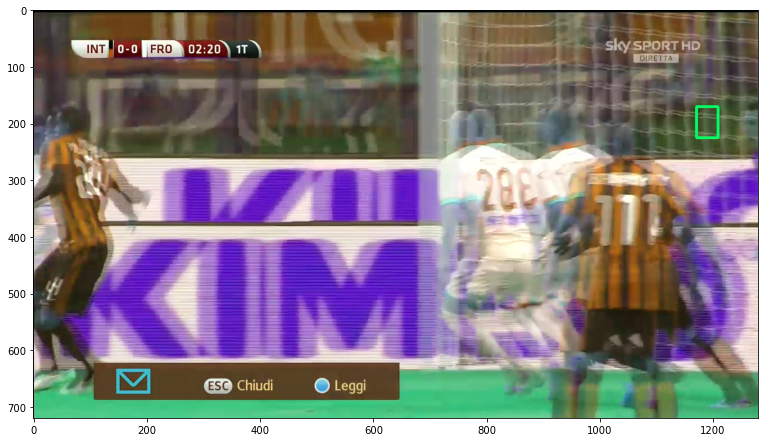

In [22]:
image_path = '../../../mnt/DATA/datasets/soccernet/italy_serie-a/2015-2016/2015-11-22 - 22-45 Inter 4 - 0 Frosinone/1_HQ/frames/01124.jpg'
image4 = cv2.imread(image_path)

#cv2.rectangle(image4, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
cv2.rectangle(image4, (face[0], face[1]), (face[2],face[3]), (0,255,100), 3) 
fig = plt.figure(figsize=(15,7.5)) 
plt.imshow(image4)
plt.show() 

['00996',
 '01085',
 '01089',
 '01091',
 '01094',
 '01095',
 '01096',
 '01098',
 '01099',
 '01100',
 '01101',
 '01103',
 '01104',
 '01106',
 '01107',
 '01110',
 '01112',
 '01114',
 '01115',
 '01116',
 '01117',
 '01118',
 '01119',
 '01120',
 '01121',
 '01122',
 '01123',
 '01124',
 '01125',
 '01126',
 '01127',
 '01128',
 '01129',
 '01130',
 '01131',
 '01132',
 '01133',
 '01134',
 '01135',
 '01136',
 '01137',
 '01138',
 '01139',
 '01140',
 '01141',
 '01142',
 '01143',
 '01144',
 '01145',
 '01146',
 '01147',
 '01148',
 '01149',
 '01150',
 '01151',
 '01152',
 '01153',
 '01154',
 '01155',
 '01156',
 '01157',
 '01158',
 '01159',
 '01160',
 '01161',
 '01162',
 '01163',
 '01164',
 '01165',
 '01166',
 '01167',
 '01168',
 '01169',
 '01170',
 '01171',
 '01172',
 '01173',
 '01174',
 '01175',
 '01176',
 '01177',
 '01178',
 '01179',
 '01180',
 '01181',
 '01182',
 '01183',
 '01184',
 '01185',
 '01186',
 '01187',
 '01188',
 '01189',
 '01267',
 '01268',
 '01269',
 '01271',
 '01272',
 '01273',
 '01274',
